# Home Loan Risk Prediction 

- Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience.
- In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

## Importing important libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import loadtxt
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import ADASYN

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,roc_auc_score,roc_curve

from sklearn.naive_bayes import GaussianNB

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier



### Importing Dataset

In [3]:
df = pd.read_csv('train_data.csv')

### Steps of Preprocessing
- Removing Nulls
- Removing House Details 47 columns with 1 column with 0/1
- Removing Flag Docs with less Correlation
- Categorical Data Handling

In [4]:
col = df.columns

# printing null values in each column
for i in col:
    print(i, '\t', df[i].isnull().sum())    # isna() and isnull() both are exactly same
    print()

SK_ID_CURR 	 0

NAME_CONTRACT_TYPE 	 0

CODE_GENDER 	 0

FLAG_OWN_CAR 	 0

FLAG_OWN_REALTY 	 0

CNT_CHILDREN 	 0

AMT_INCOME_TOTAL 	 0

AMT_CREDIT 	 0

AMT_ANNUITY 	 6

AMT_GOODS_PRICE 	 167

NAME_TYPE_SUITE 	 770

NAME_INCOME_TYPE 	 0

NAME_EDUCATION_TYPE 	 0

NAME_FAMILY_STATUS 	 0

NAME_HOUSING_TYPE 	 0

REGION_POPULATION_RELATIVE 	 0

DAYS_BIRTH 	 0

DAYS_EMPLOYED 	 0

DAYS_REGISTRATION 	 0

DAYS_ID_PUBLISH 	 0

OWN_CAR_AGE 	 121633

FLAG_MOBIL 	 0

FLAG_EMP_PHONE 	 0

FLAG_WORK_PHONE 	 0

FLAG_CONT_MOBILE 	 0

FLAG_PHONE 	 0

FLAG_EMAIL 	 0

OCCUPATION_TYPE 	 57867

CNT_FAM_MEMBERS 	 1

REGION_RATING_CLIENT 	 0

REGION_RATING_CLIENT_W_CITY 	 0

WEEKDAY_APPR_PROCESS_START 	 0

HOUR_APPR_PROCESS_START 	 0

REG_REGION_NOT_LIVE_REGION 	 0

REG_REGION_NOT_WORK_REGION 	 0

LIVE_REGION_NOT_WORK_REGION 	 0

REG_CITY_NOT_LIVE_CITY 	 0

REG_CITY_NOT_WORK_CITY 	 0

LIVE_CITY_NOT_WORK_CITY 	 0

ORGANIZATION_TYPE 	 0

EXT_SOURCE_1 	 104074

EXT_SOURCE_2 	 413

EXT_SOURCE_3 	 36656

APARTMENTS_

#### Let's see how many people have actually paid their debt and how many not

<AxesSubplot:xlabel='TARGET', ylabel='count'>

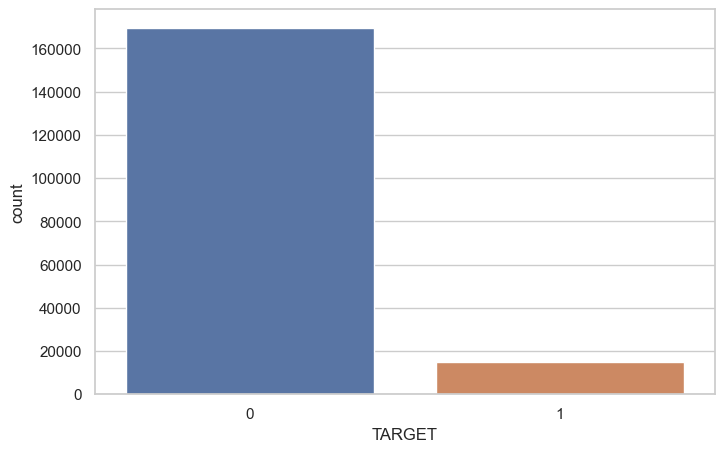

In [5]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style('whitegrid')
sns.countplot(x='TARGET', data=df)

- Here we can see that our dataset is imbalance, so it will definitely affect the model training. Here we need to perform some data sampling technique

### Now the normalized column which contains all the housing details contains a lot of null, we cannot simply dump those columns, so let's create a new column which would contain [0, 1] based on the fact whether client didn't provided any details or had given some details

In [6]:
col_to_del = list(col[43:90])

rng = len(df[col_to_del[2]])

z = pd.DataFrame(df, columns=col_to_del)

z.fillna(value=-1, inplace=True) 

In [7]:
col_to_del

['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMER

- Data was normalized so to compare nan which cannot be directly compared even with np.nan, we replaced all nan with -1

In [6]:
new_fe = []
for i in range(rng):
    b = False
    for j in range(len(col_to_del)):
        if z[col_to_del[j]][i] != -1:
            b = True
            break
        else:  pass
    
    if b : new_fe.append(1)  # The client i has provided atleast any of the details about the house.
    else: new_fe.append(0)   # The client i didn't provided any of the house details.
            

In [7]:
dataFrame = pd.DataFrame(new_fe, columns=['HouseDetails'])

copy_df = df.copy()

copy_df.drop(col_to_del, axis=1, inplace=True)

copy_df.insert(43, "House_Details", new_fe)

df = copy_df

<AxesSubplot:>

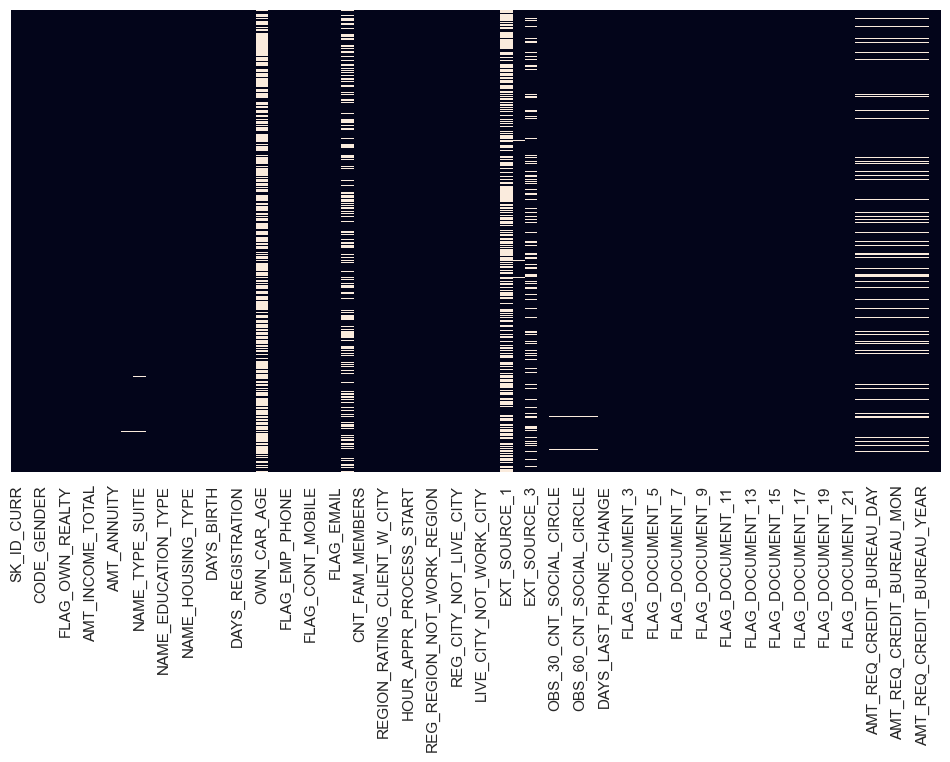

In [8]:
# Again plotting the Heatmap to visualize the null values
sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

<AxesSubplot:xlabel='TARGET', ylabel='count'>

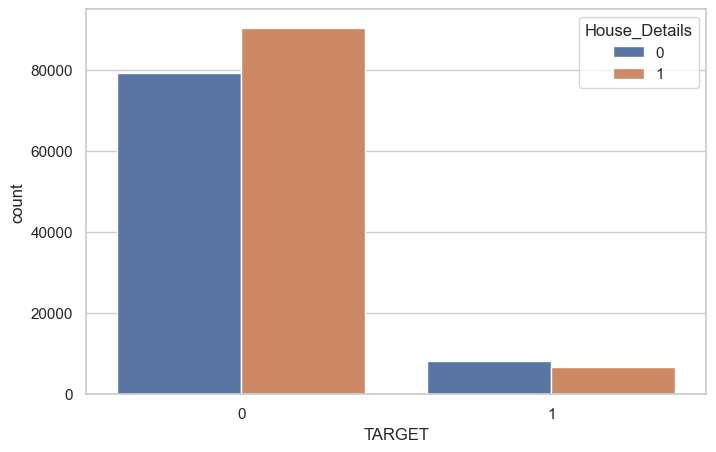

In [9]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style('whitegrid')
sns.countplot(x='TARGET', hue='House_Details', data=df)

- Data is still not enough to show that the person who has given house details are much more intended to repay the loan but still we can see from the above plot that one with there house details repaid more than who has not given their House details

In [10]:
col_to_del.remove('FONDKAPREMONT_MODE')
col_to_del.remove('HOUSETYPE_MODE')
col_to_del.remove('WALLSMATERIAL_MODE')
col_to_del.remove('EMERGENCYSTATE_MODE')

In [11]:
col_with_null = []

for i in list(df.columns):
    if df[i].isna().sum() > 100000:
        col_with_null.append(i)
    else: pass
    

In [12]:
df.drop(col_with_null, axis=1, inplace=True)

### Replacing Missing Values of Numerical Columns

In [13]:
numerical_columns = [col for col in df.columns if df[col].dtypes != 'O']


In [14]:
# Removing numerical categorical columns
for i in numerical_columns:
    if df[i].nunique() == 2:
        numerical_columns.remove(i)

In [15]:
# Retrieving Columns which has atleast 1 null value from the numerical columns list

col_to_impute = []
for i in numerical_columns:
    if df[i].isna().sum() > 0:
        col_to_impute.append(i)

#### Replacing with Mean

In [16]:
for i in col_to_impute:
    df[i].fillna(df[i].mean(), inplace=True)

## Flag Doc 12 contains only 0, drop it

In [17]:
df.drop('FLAG_DOCUMENT_12', axis=1, inplace=True)

In [18]:
col = df.columns

# printing null values in each column
for i in col:
    if df[i].isna().sum() > 0:
        print(i, '\t', df[i].isnull().sum())    # isna() and isnull() both are exactly same
        print()

NAME_TYPE_SUITE 	 770

OCCUPATION_TYPE 	 57867



## Now Let's deal with FLAG_DOCUMENTS

In [19]:
df['FLAG_DOCUMENT_2'].nunique()

2

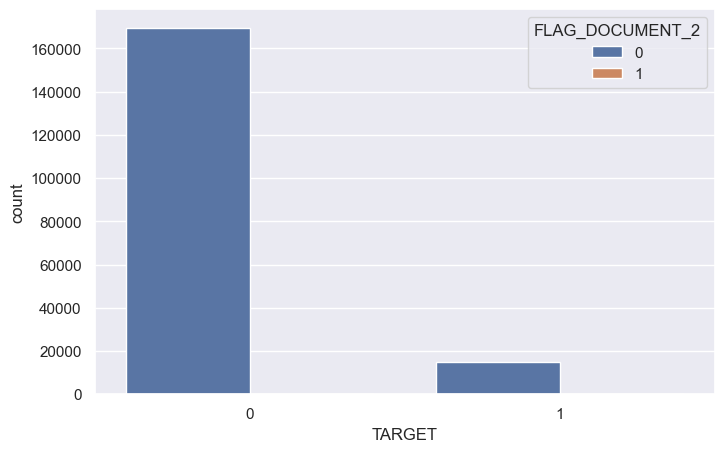

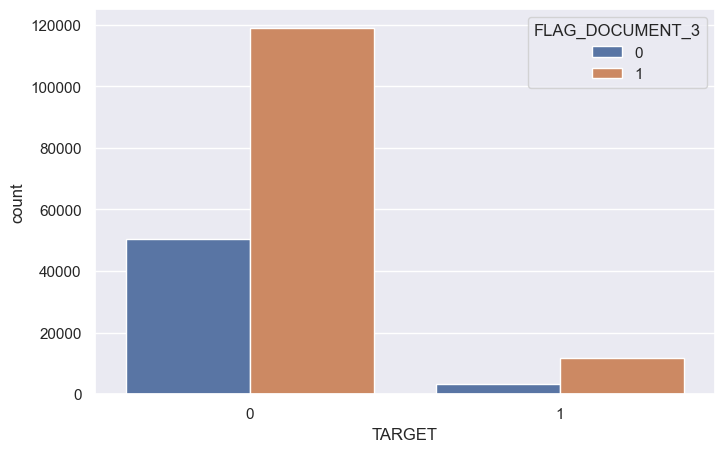

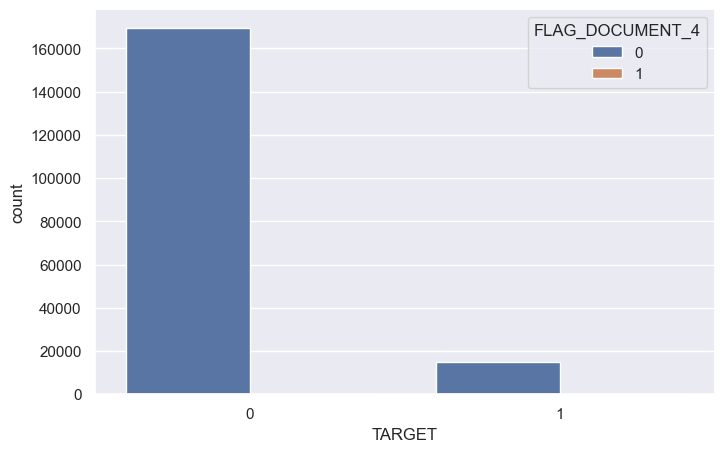

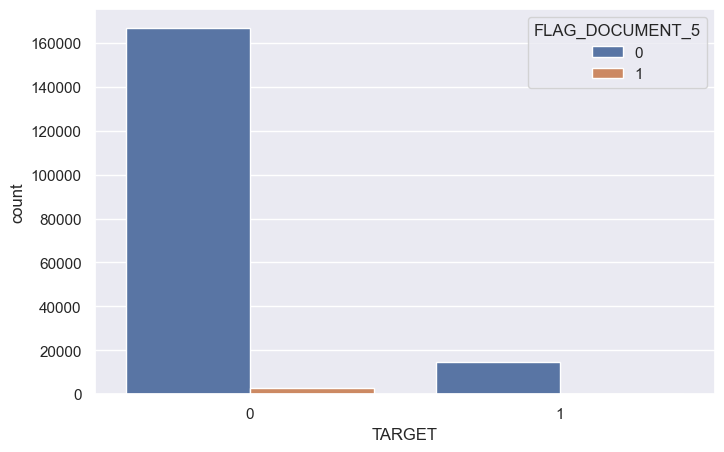

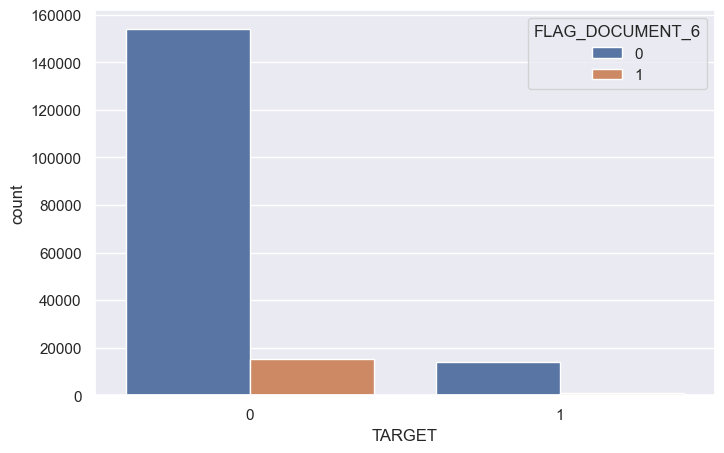

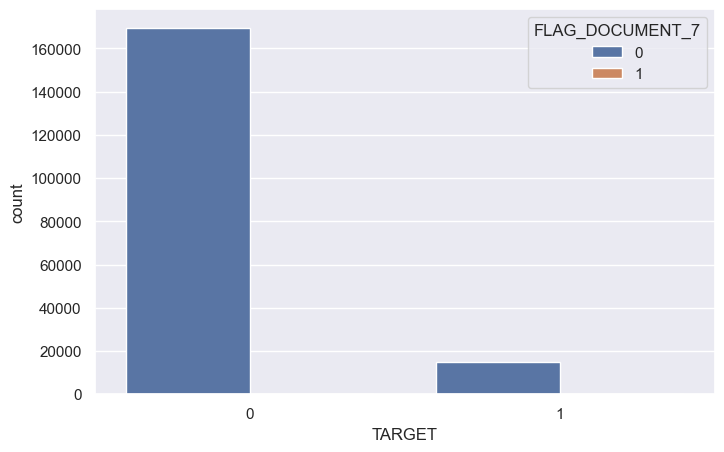

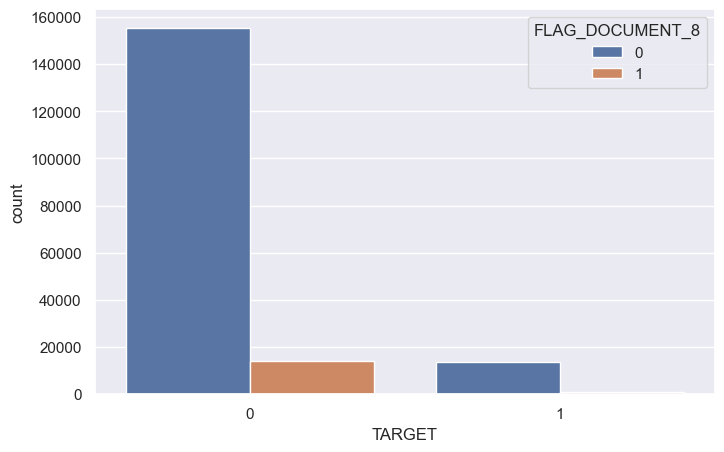

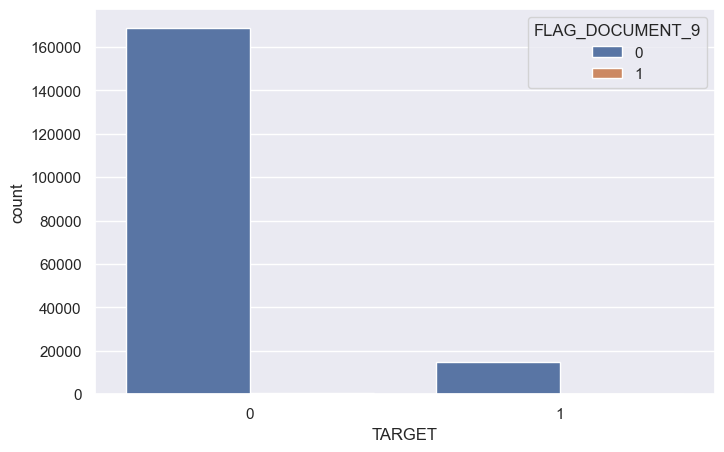

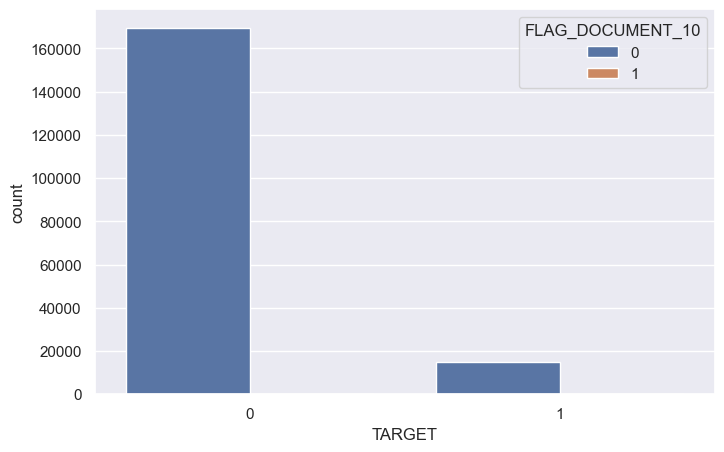

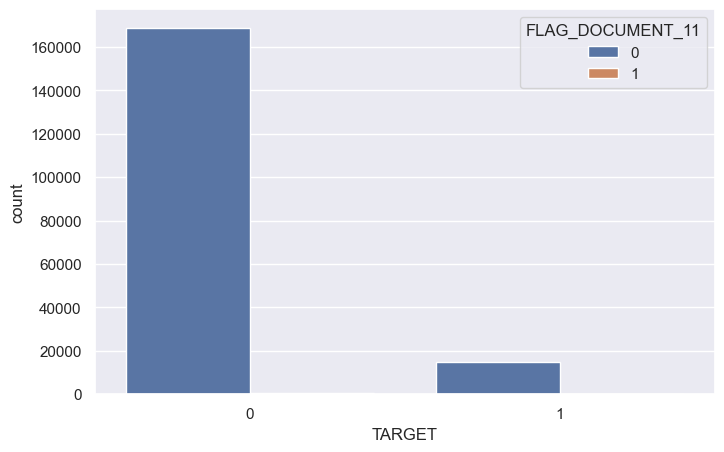

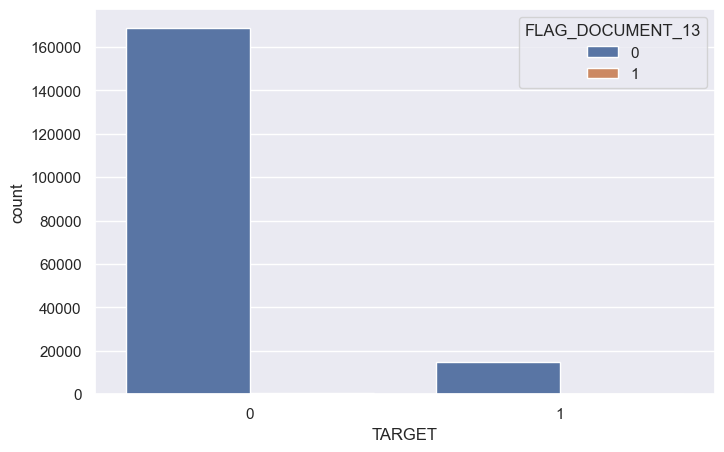

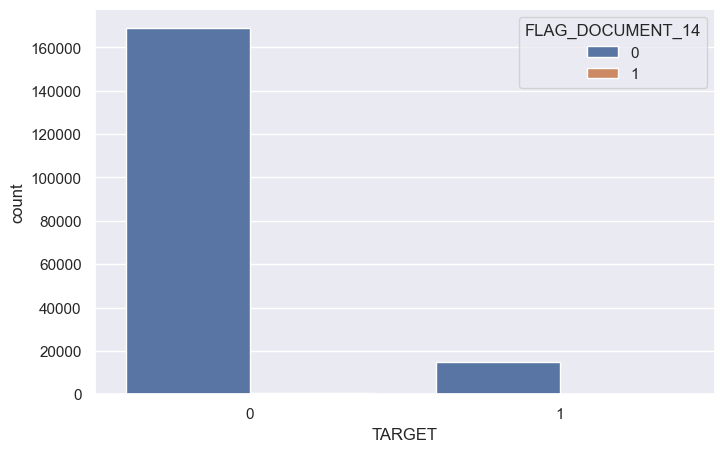

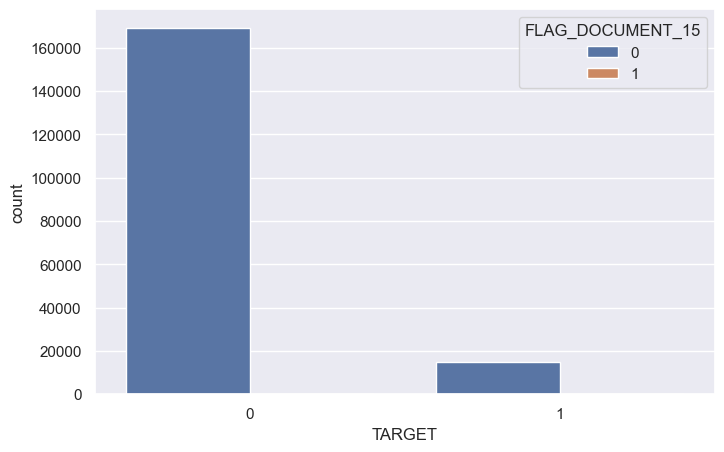

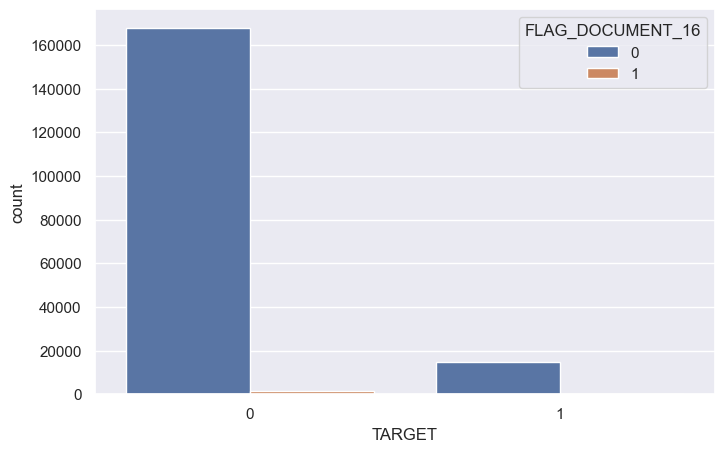

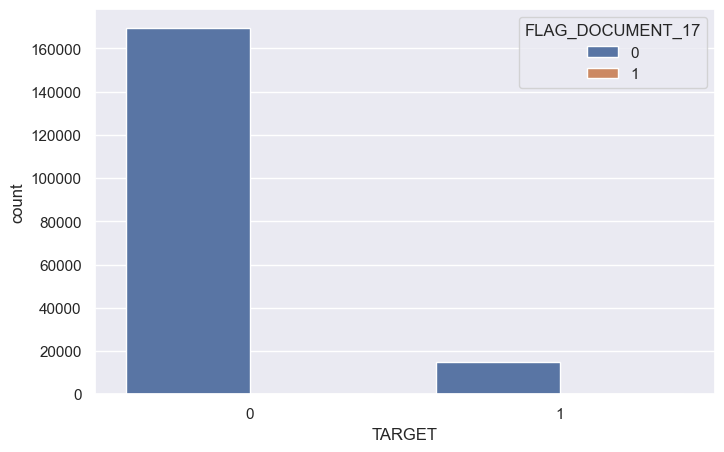

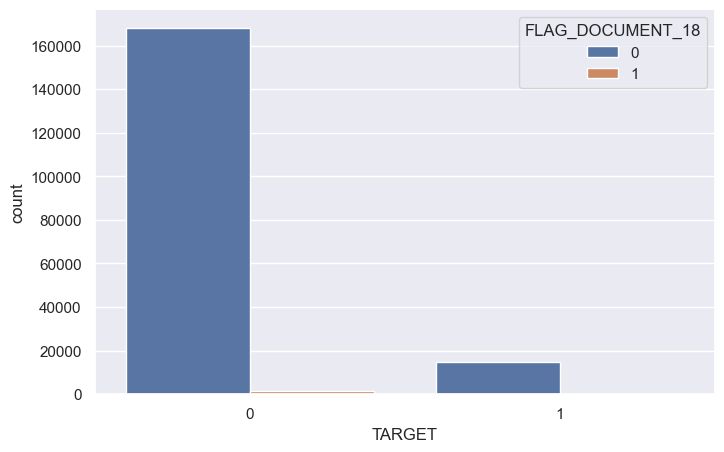

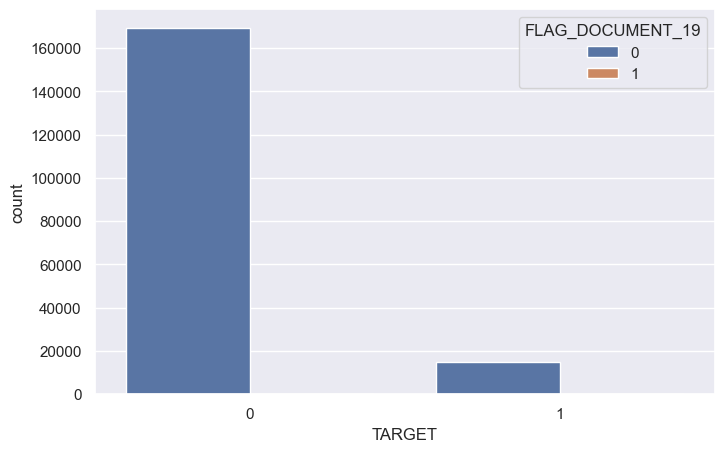

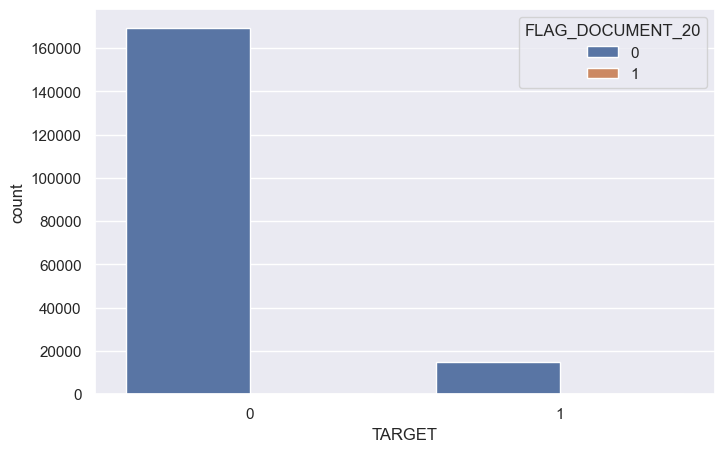

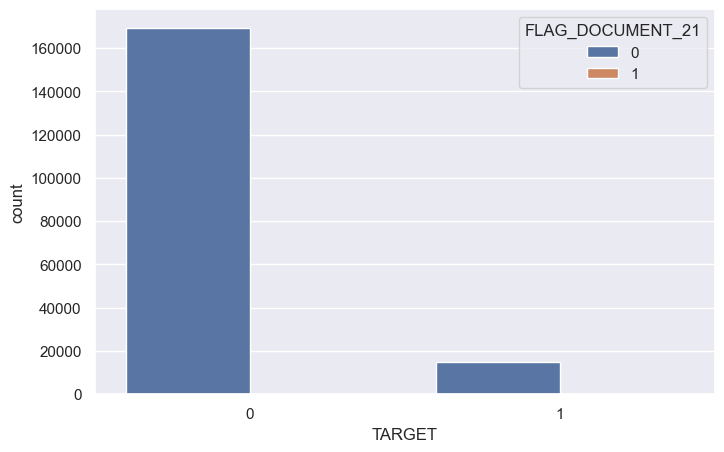

In [20]:
sns.set(rc = {'figure.figsize':(8,5)})
for i in range(2, 22):
    if i == 12:
        pass
    else:
        sns.countplot(x='TARGET', hue='FLAG_DOCUMENT_'+str(i), data=df)
        plt.show()

- From the above plots we can see that these documents (which do not have much description as well) has no impact with the TARGET column 

In [21]:
for i in range(2, 22):
    if i == 12:
        pass
    else:
        print(df['FLAG_DOCUMENT_'+str(i)].corr(df['TARGET']))

0.004634872141845338
0.04773747359402927
-0.00284467377287488
-0.00018901328908296476
-0.03181473987375815
0.0004998065647304759
-0.008833852413835955
-0.0026246025685616363
-0.0013798208494405987
-0.0031357732194645877
-0.01227175170295454
-0.010142299787198678
-0.007906820706059716
-0.010793342401918685
-0.0036702745943404096
-0.00860528769008559
0.0005043486606742012
-0.0001983687500499209
-0.0009310310332142522


In [22]:
flag_list = []

for i in range(2, 22):
    if i == 12:
        pass
    else:
        flag_list.append('FLAG_DOCUMENT_'+str(i))

In [23]:
flag_list.append('TARGET')

<AxesSubplot:>

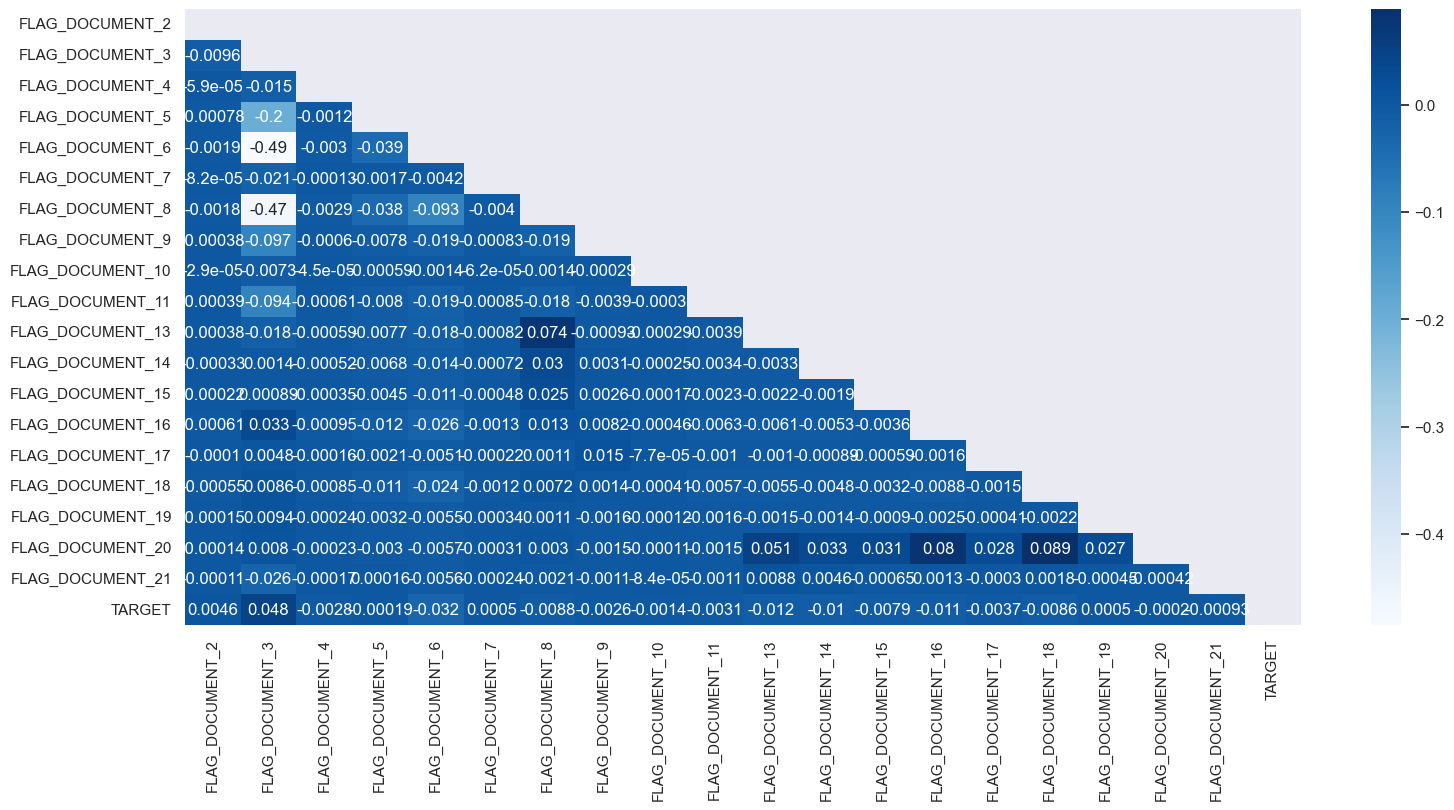

In [24]:
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(df[flag_list].corr()))
sns.heatmap(df[flag_list].corr(), cmap='Blues', annot=True, mask=mask)

- Among all the FLAG_DOCUMENTS only FLAG_DOCUMENT_3 has better correlation with TARGET column, so therefore we'll remove rest of the FLAG_DOCUMENTS

In [25]:
flag_list.remove('TARGET')

flag_list.remove('FLAG_DOCUMENT_3')

df.drop(flag_list, axis=1, inplace=True)

## Let's drop ID column

In [26]:
df.drop('SK_ID_CURR', axis=1, inplace=True)

## Dealing with Categorical Columns

In [27]:
categorical_feat=[col for col in df.columns if df[col].dtypes =='O']

In [28]:
categorical_feat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [29]:
# checking null in all above columns
cat_with_null = []

for i in categorical_feat:
    if df[i].isna().sum() > 0:
        cat_with_null.append(i)

In [30]:
cat_with_null

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE']

In [31]:
df['OCCUPATION_TYPE'].fillna('NA', inplace=True)

<AxesSubplot:xlabel='TARGET', ylabel='count'>

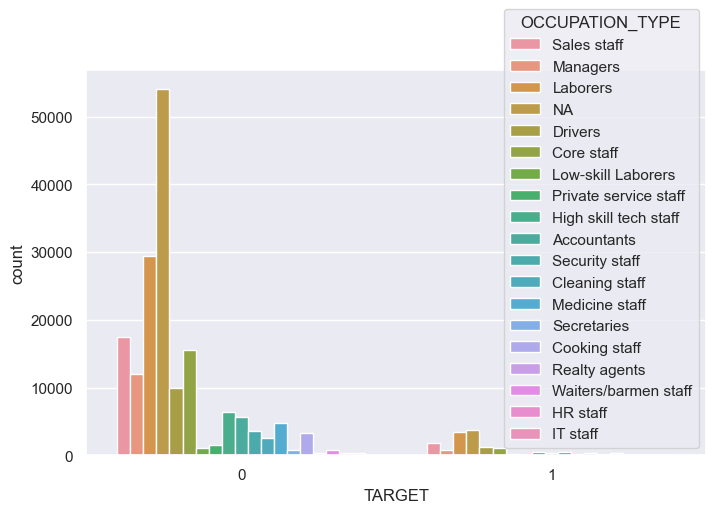

In [32]:
sns.countplot(x='TARGET', hue='OCCUPATION_TYPE', data=df)

- One who don't work has paid more loan

In [33]:
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna(df['NAME_TYPE_SUITE'].mode().iloc[0])

#### XNA's are present in some columns

In [34]:
for i in df.columns:
    if 'XNA' in df[i].unique():
        print(i)

CODE_GENDER


C:\Users\vivek singh\AppData\Local\Temp\ipykernel_7620\4289376026.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'XNA' in df[i].unique():


ORGANIZATION_TYPE


#### Filling XNA's with MODE()

In [35]:
df.loc[df["CODE_GENDER"] == "XNA", "CODE_GENDER"] = 'F'
df.loc[df['ORGANIZATION_TYPE'] == 'XNA', 'ORGANIZATION_TYPE'] = 'Business Entity Type 3'

## Outlier detection


In [36]:
Num_feat=[col for col in df.columns if df[col].dtypes != 'O']
dis_feat=[feat for feat in Num_feat if (df[feat].nunique()<3)]
lis=list(set(Num_feat).symmetric_difference(set(dis_feat)))

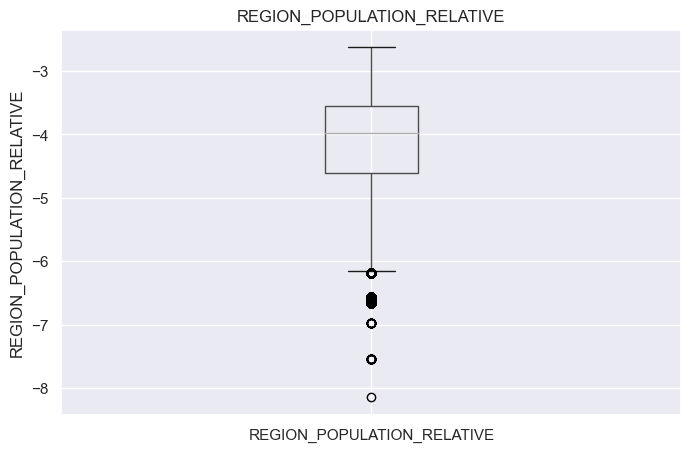

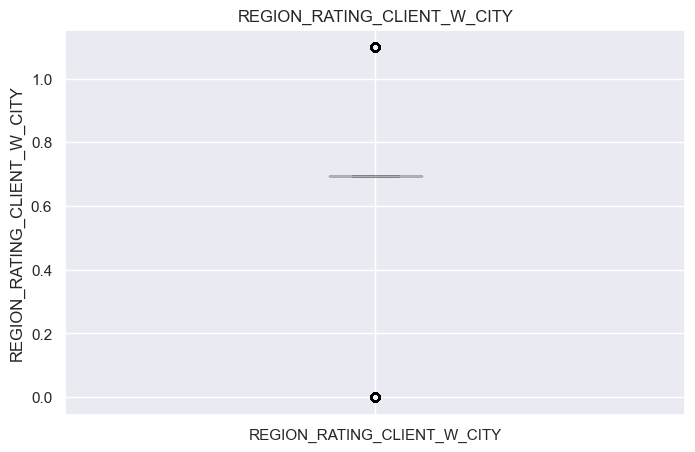

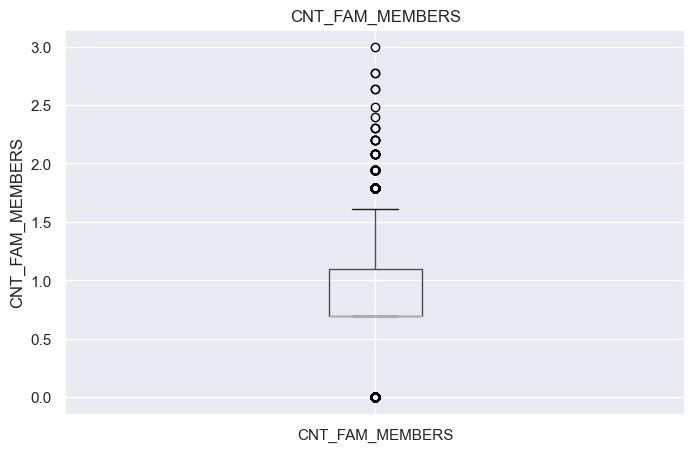

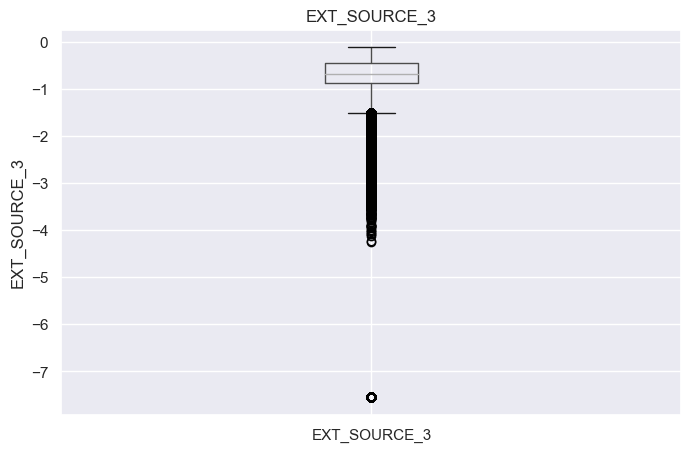

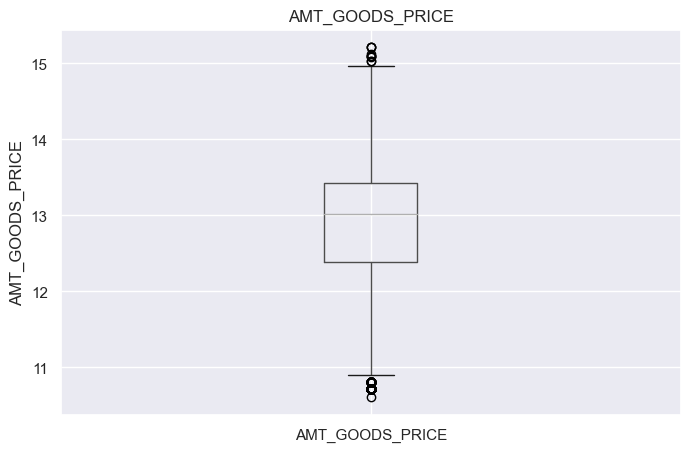

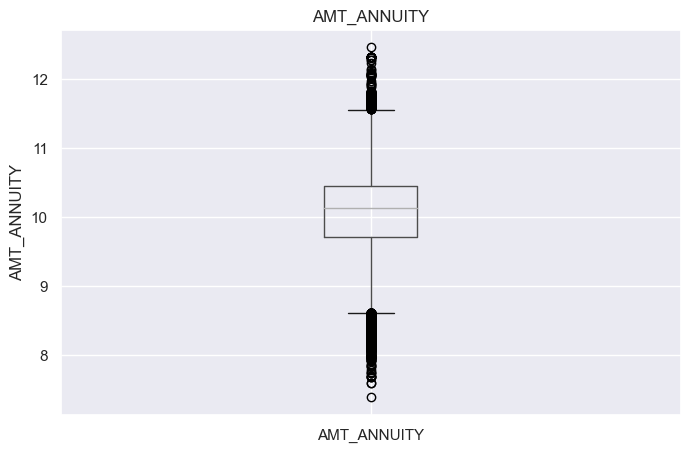

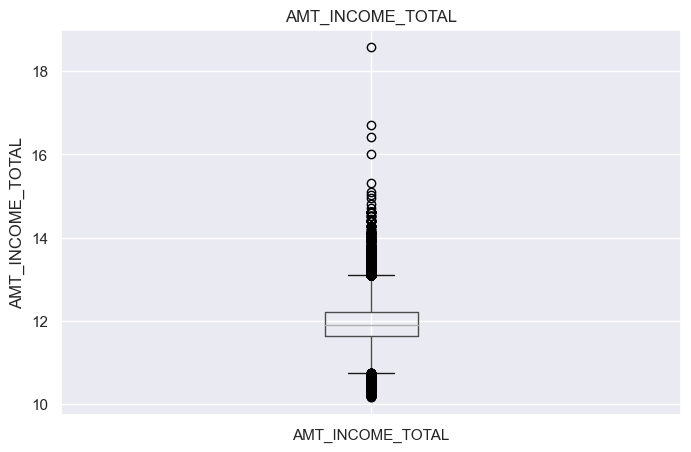

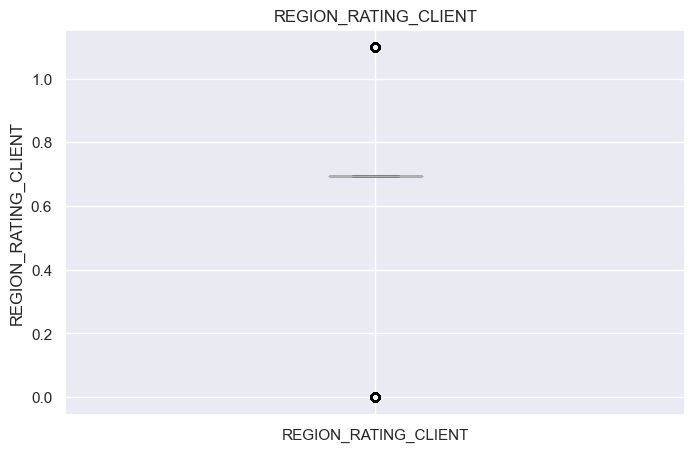

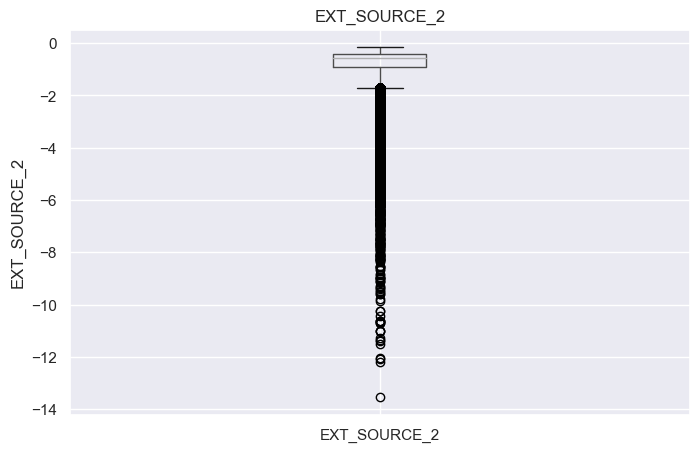

C:\Users\vivek singh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


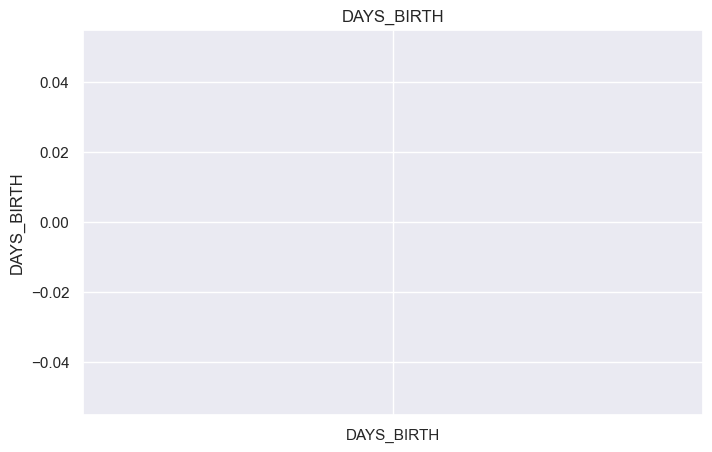

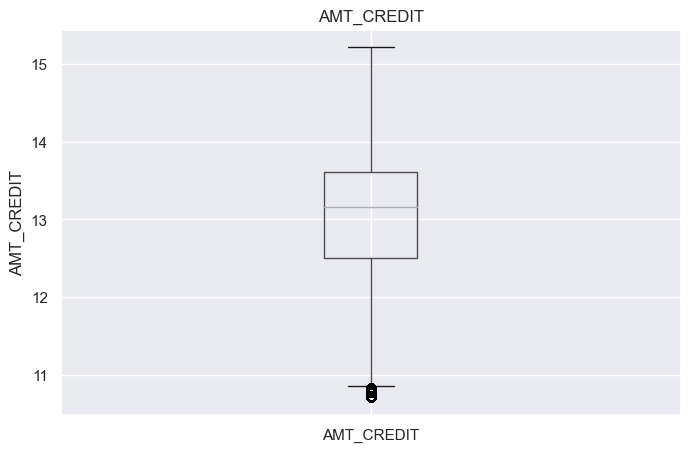

In [37]:
#Outliers

for col in lis:
    data=df.copy()
    if 0 in data[col].unique():
        pass
    else:
        data[col]=np.log(data[col])
        data.boxplot(column=col)
#         plt.xlabel(col)
        plt.ylabel(col)
        plt.title(col)
        plt.show()

In [38]:
class OutlierRemoval: 
    def __init__(self, lower_quartile, upper_quartile):
        self.lower_whisker = lower_quartile - 1.5*(upper_quartile - lower_quartile)
        self.upper_whisker = upper_quartile + 1.5*(upper_quartile - lower_quartile)
    def removeOutlier(self, x):
        return (x if x <= self.upper_whisker and x >= self.lower_whisker 
                else (self.lower_whisker if x < self.lower_whisker else (self.upper_whisker)))

In [39]:
for i in lis:
  obj = OutlierRemoval(df[i].quantile(0.05), df[i].quantile(0.95))
  df[i]=df[i].apply(obj.removeOutlier)

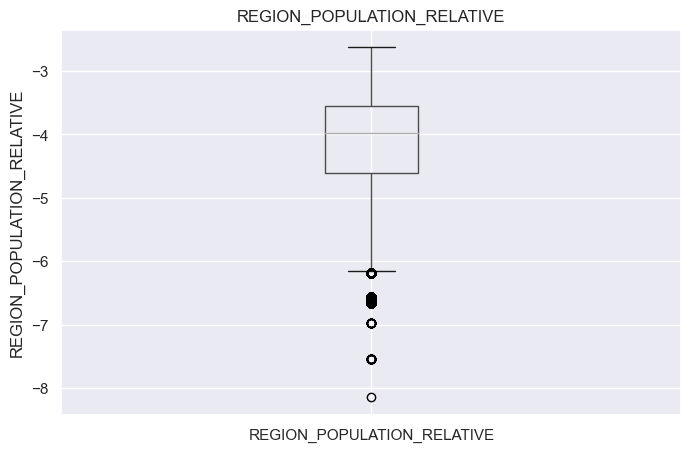

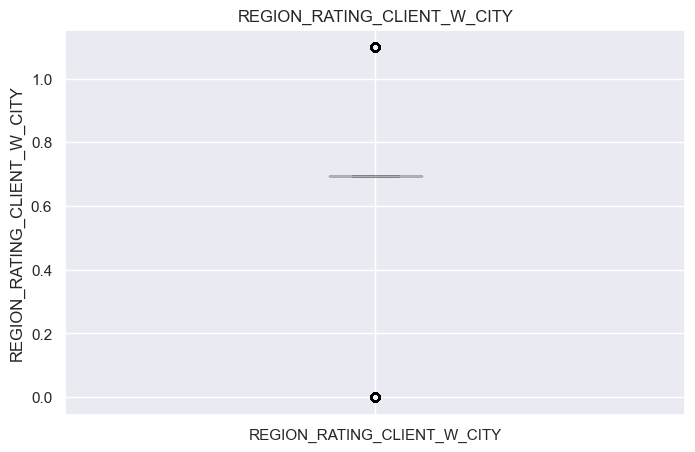

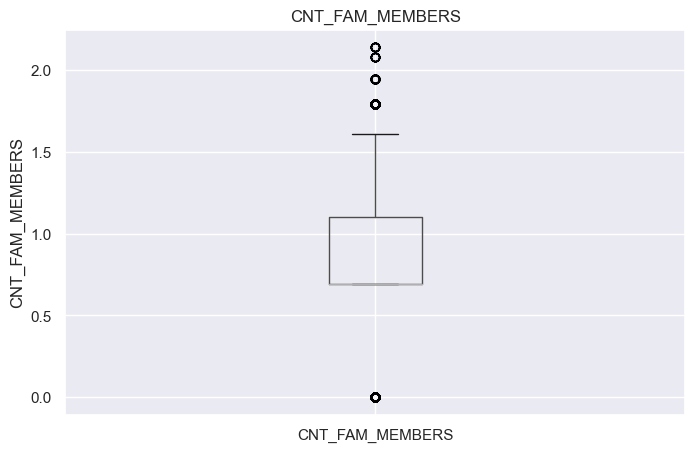

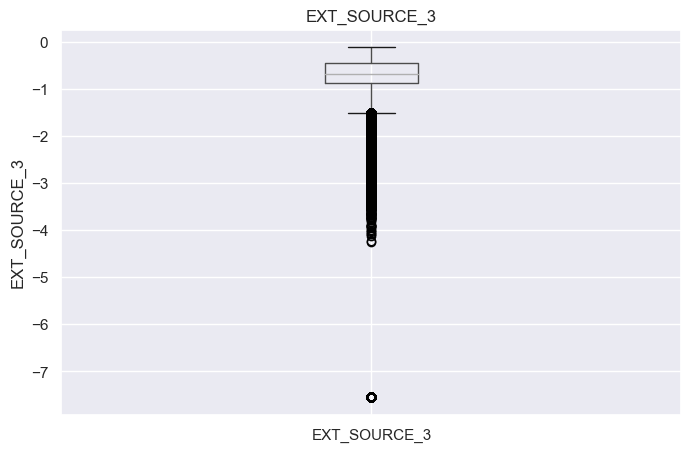

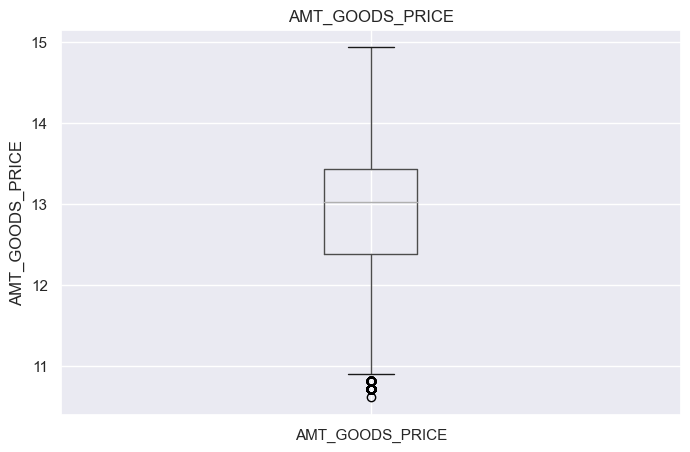

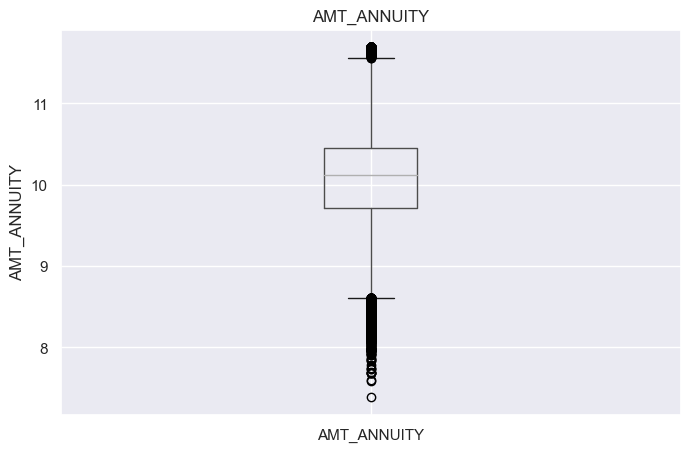

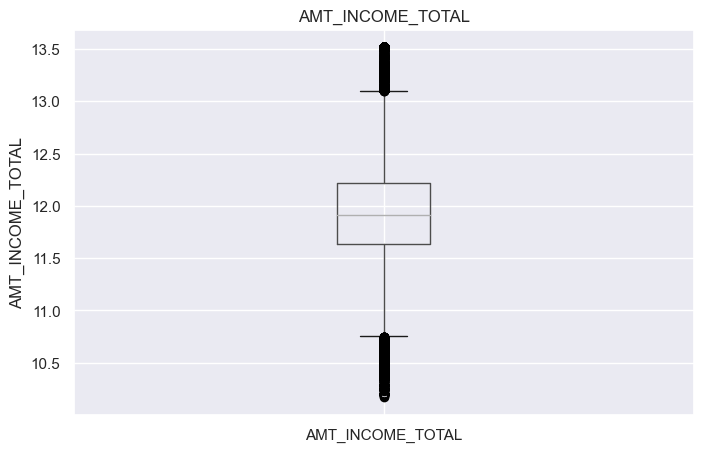

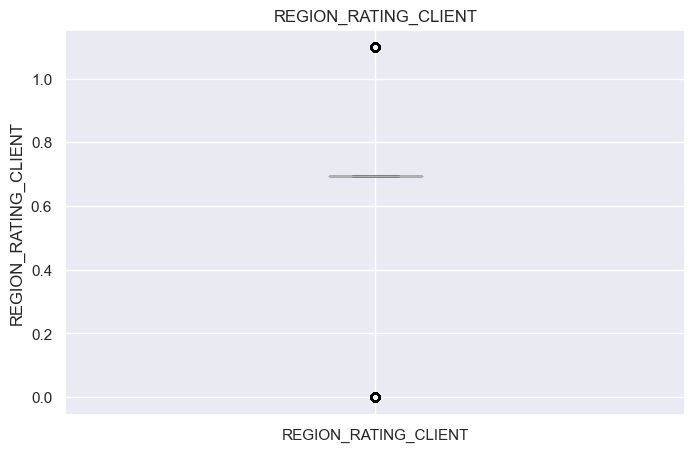

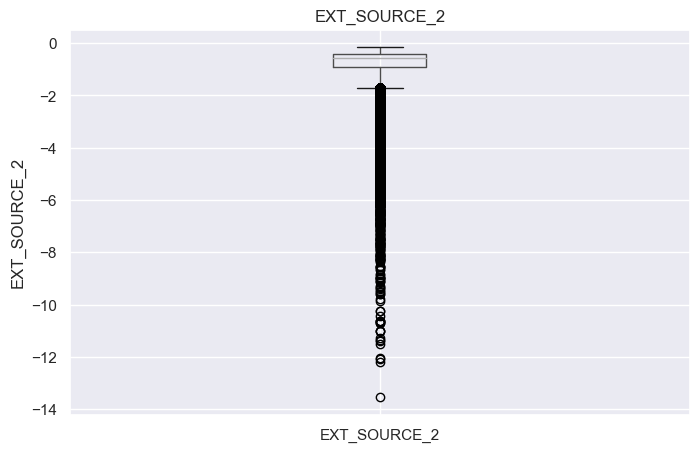

C:\Users\vivek singh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


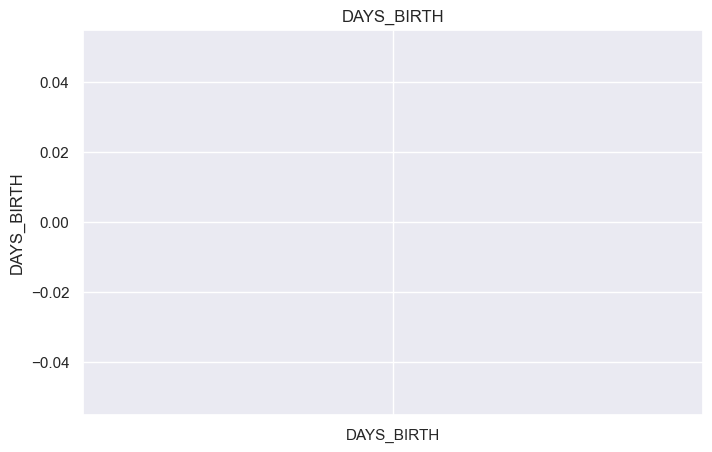

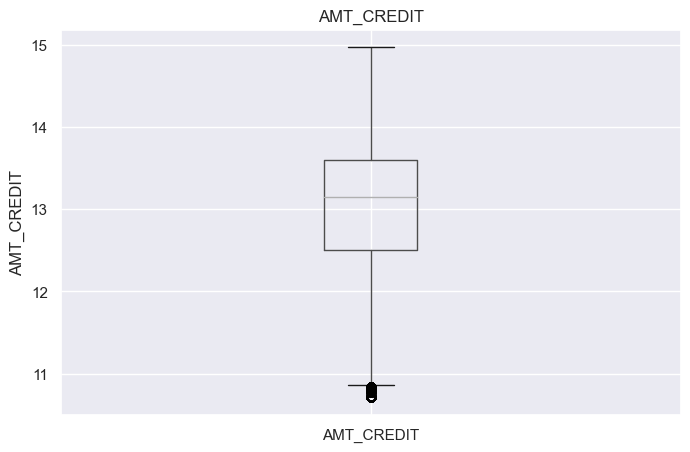

In [40]:
#Outliers

for col in lis:
    data=df.copy()
    if 0 in data[col].unique():
        pass
    else:
        data[col]=np.log(data[col])
        data.boxplot(column=col)
#         plt.xlabel(col)
        plt.ylabel(col)
        plt.title(col)
        plt.show()

## Label Encoding the Categorical columns

In [41]:
le = LabelEncoder()
copy_df[categorical_feat] = copy_df[categorical_feat].apply(LabelEncoder().fit_transform)

### Selecting K best columns

### Removing -ve values 
#### (since k best feat don't work on negative values)

In [42]:
Num_feat=[col for col in df.columns if df[col].dtypes != 'O']
dis_feat=[feat for feat in Num_feat if (df[feat].nunique()<3)]
lis=list(set(Num_feat).symmetric_difference(set(dis_feat)))

In [43]:
### Replacing -ve with 0 in Numerical Columns
num = df._get_numeric_data()
num[num < 0] = 0
neg_col=[(df[lis] < 0).any()]
# neg_col

In [44]:
Y = df['TARGET']
X = df.drop('TARGET', axis=1)
sel_feat = SelectKBest(chi2, k=20).fit(X,Y)

In [45]:
sel_bool= sel_feat.get_support()

x_sel=X[X.columns[sel_bool]]
x_sel.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,House_Details,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0,67500.0,227520.0,11065.5,180000.0,1,4,1,0,1,0,0,0,5,0.264354,0.510894,1,0.0,0.0
1,0,1,247500.0,1882372.5,65560.5,1719000.0,7,1,1,0,0,0,1,1,5,0.172251,0.686382,0,0.0,0.0
2,0,1,180000.0,101880.0,10827.0,90000.0,7,1,1,0,1,0,0,0,55,0.636218,0.540654,1,0.0,0.0
3,0,1,81000.0,405000.0,20677.5,405000.0,7,4,5,0,1,0,1,1,33,0.599924,0.337673,0,1.0,1.0
4,0,0,157500.0,888840.0,29506.5,675000.0,7,4,1,0,0,0,1,1,5,0.312779,0.819318,0,0.0,0.0


### Data balancing

In [46]:
X_resampled, y_resampled = ADASYN().fit_resample(x_sel, Y)

### Test Train Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled ,random_state=104, test_size=0.25, shuffle=True)

## Models Applied
- Logistic Regression
- XGBoost
- LGBM
- Naive Bayes
- Random Forrest

### Logistic Regression

In [48]:
logreg = LogisticRegression(random_state=25,max_iter=20000)

logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

lr_roc = roc_auc_score(y_test, y_pred_lr)
print(roc_auc_score(y_test, y_pred_lr))

print(f1_score(y_test,y_pred_lr))

Accuracy: 56.11%
0.5610465329005788
0.5752803383335034


### XGBoost
- Best so far among all the applied models

In [49]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

# Evaluate Predictions
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

xg_roc = roc_auc_score(y_test, y_pred_xgb)
print(roc_auc_score(y_test, y_pred_xgb))

print(f1_score(y_test,y_pred_xgb))

Accuracy: 89.33%
0.8933814366983146
0.889949493729006


## HyperParameter tuning for XGBoost

In [50]:
# # Hypertunuing 
# ## Hyper Parameter Optimization

# params={
#  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
# }

# ## Hyperparameter optimization using RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import xgboost
# classifier=xgboost.XGBClassifier()

In [51]:
# random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [52]:
# random_search.fit(X_train,y_train)

In [53]:
#  random_search.best_estimator_

In [54]:
# random_search.best_params_
# print(random_search.best_params_)

In [55]:
# classifier=xgboost.XGBClassifier(
#              min_child_weight =1,max_depth = 15,learning_rate = 0.2,gamma = 0.1,colsample_bytree = 0.5)
# classifier.fit(X_train, y_train)
# # make predictions for test data
# y_pred = classifier.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# y_roc=roc_auc_score(y_test, y_pred)
# f1=f1_score(y_test,y_pred)
# print(accuracy )
# print((y_roc ))
# print((f1 ))

### LightGBM

In [56]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [57]:
mod = LGBMClassifier()
mod.fit(X_train, y_train)
lg_pred = mod.predict(X_test)

In [58]:
# evaluate predictions
accuracy = accuracy_score(y_test, lg_pred)
lg_roc=roc_auc_score(y_test, lg_pred)
f1=f1_score(y_test,lg_pred)
print( (accuracy))
print(lg_roc )
print((f1 ))

0.8685943248119596
0.8687109594759086
0.8630959646510266


In [59]:
# ##Hyperparameter tuning
# import optuna  # pip install optuna
# from sklearn.metrics import log_loss
# from sklearn.model_selection import StratifiedKFold

# def objective(trial, X, y):
#     param_grid = {}  # to be filled in later
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

#     cv_scores = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

#         model = lgbm.LGBMClassifier(objective="binary", **param_grid)
#         model.fit(
#             X_train,
#             y_train,
#             eval_set=[(X_test, y_test)],
#             eval_metric="binary_logloss",
#             early_stopping_rounds=100,
#         )
#         preds = model.predict_proba(X_test)
#         cv_scores[idx] = preds

#     return np.mean(cv_scores)

In [60]:
# from optuna.integration import LightGBMPruningCallback

# def objective(trial, X, y):
#     param_grid = {
#         # "device_type": trial.suggest_categorical("device_type", ['gpu']),
#         "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.95, step=0.1
#         ),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.95, step=0.1
#         ),
#     }

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

#     cv_scores = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

#         model = lgbm.LGBMClassifier(objective="binary", **param_grid)
#         model.fit(
#             X_train,
#             y_train,
#             eval_set=[(X_test, y_test)],
#             eval_metric="binary_logloss",
#             early_stopping_rounds=100,
#             callbacks=[
#                 LightGBMPruningCallback(trial, "binary_logloss")
#             ],  # Add a pruning callback
#         )
#         preds = model.predict_proba(X_test)
#         cv_scores[idx] = log_loss(y_test, preds)

#     return np.mean(cv_scores)

In [61]:
# study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
# func = lambda trial: objective(trial, X_resampled, y_resampled)
# study.optimize(func, n_trials=20)

In [62]:
# print(f"\tBest value (rmse): {study.best_value:.5f}")
# print(f"\tBest params:")

# for key, value in study.best_params.items():
#     print(f"\t\t{key}: {value}")

In [63]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(n_estimators=10000, learning_rate=0.29802309035646496, num_leaves=1960, max_depth=3, max_data_in_leaf=200, lamda_l1=0, lambda_l2=0 , min_gain_to_split=0.008217887778824803, bagging_fraction=0.4, bagging_freq=1, feature_fraction=0.4)

lgb.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: max_data_in_leaf
[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.008217887778824803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008217887778824803
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.4, bagging_freq=1, feature_fraction=0.4,
               lambda_l2=0, lamda_l1=0, learning_rate=0.29802309035646496,
               max_data_in_leaf=200, max_depth=3,
               min_gain_to_split=0.008217887778824803, n_estimators=10000,
               num_leaves=1960)

In [64]:
y_pred_lgbm = lgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lgbm)

accuracy
lg_roc = roc_auc_score(y_test, y_pred_lgbm)

f1=f1_score(y_test, y_pred_lgbm)
print(accuracy)
print(lg_roc)
print(f1)

0.8982707313072615
0.8983361653933285
0.8960455900487267


### Naive Bayes

In [65]:
gnb = GaussianNB()

y_pred_nb = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total points :",(X_test.shape[0], (y_test != y_pred_nb).sum()))


# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_nb)
nb_roc = roc_auc_score(y_test, y_pred_nb)

f1=f1_score(y_test, y_pred_nb)
print((accuracy ))
print((nb_roc ))
print((f1 ))

Number of mislabeled points out of a total points : (85354, 37983)
0.5549944935211003
0.5544999424151583
0.6234870788354595


### Random Forest

In [66]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_rf)
rf_roc = roc_auc_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(accuracy)
print(rf_roc)
print(f1)

0.9002155727909646
0.9002630987066559
0.8987096390557175


In [67]:
#calculate AUROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_lr)
xg_fpr, xg_tpr, _ = roc_curve(y_test, y_pred_xgb)
nb_fpr, nb_tpr, _ = roc_curve(y_test, y_pred_nb)
lg_fpr, lg_tpr, _ = roc_curve(y_test, y_pred_lgbm)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_rf)

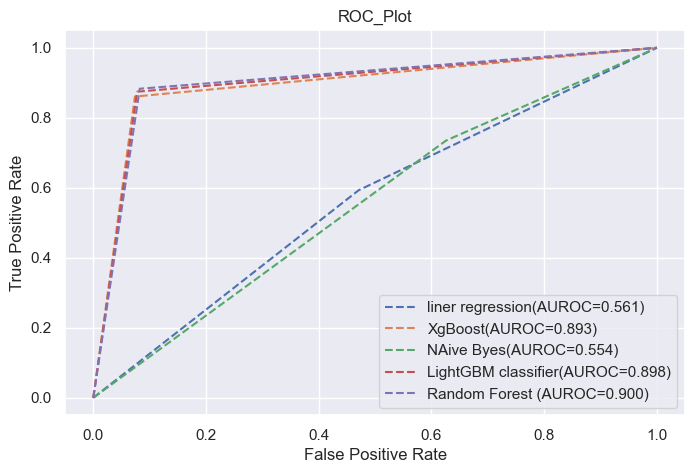

In [68]:
#plot curve
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='liner regression(AUROC=%0.3f)'%lr_roc)
plt.plot(xg_fpr, xg_tpr, linestyle='--', label='XgBoost(AUROC=%0.3f)'%xg_roc)
plt.plot(nb_fpr, nb_tpr, linestyle='--', label='NAive Byes(AUROC=%0.3f)'%nb_roc)
plt.plot(lg_fpr, lg_tpr, linestyle='--', label='LightGBM classifier(AUROC=%0.3f)'%lg_roc)
plt.plot(rf_fpr, rf_tpr, linestyle='--', label='Random Forest (AUROC=%0.3f)'%rf_roc)



plt.title('ROC_Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()